На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [49]:
from scipy.stats import ttest_1samp
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_ind, mannwhitneyu, shapiro, pearsonr

from statsmodels.stats import proportion
from statsmodels.stats.power import TTestIndPower

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [26]:
data = pd.read_excel('AB_Test_Results.xlsx')

In [27]:
data.head(20)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00
1,2423,control,0.00
2,9411,control,0.00
3,7311,control,0.00
4,6174,variant,0.00
5,2380,variant,0.00
6,2849,control,0.00
7,9168,control,0.00
8,6205,variant,0.00
9,7548,control,0.00


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Количество пользователей, участвовавших в тесте

In [29]:
data.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [30]:
data.isna().sum()


USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [31]:
data[data['REVENUE']>0]

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


In [32]:
data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


In [33]:
data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


Из анализа мы видим, что средний и максимальный чек больше в контрольной группе.

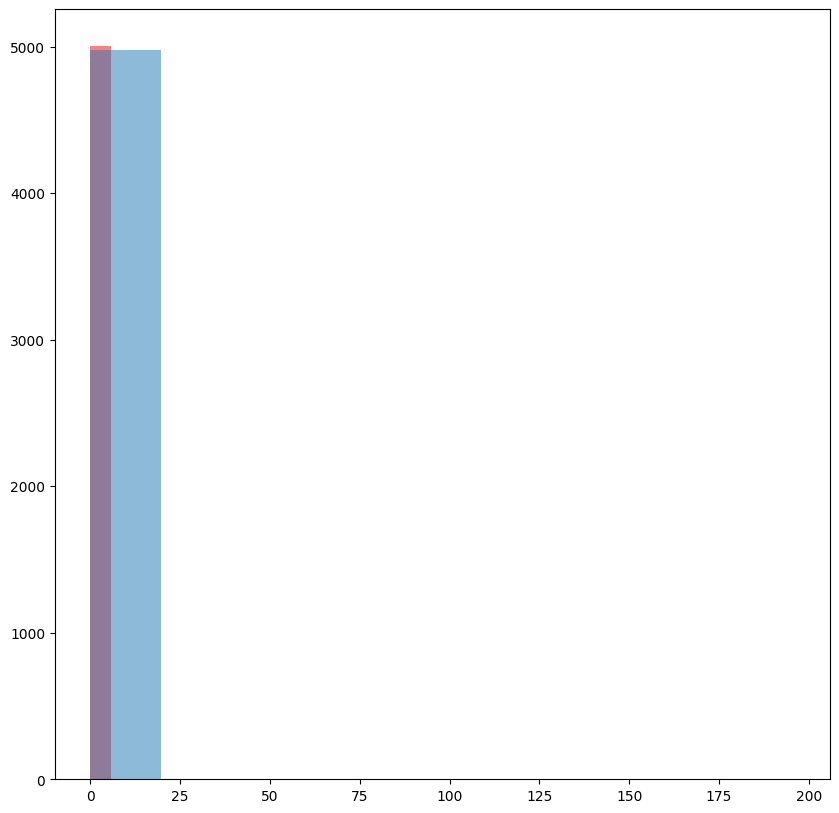

In [37]:
plt.figure(figsize=(10, 10))
control_revenue_all = data['REVENUE'][data['VARIANT_NAME'] == 'variant']
test_revenue_all =data['REVENUE'][data['VARIANT_NAME'] == 'control']

plt.hist(control_revenue_all, color='r', alpha=0.5, bins=10)
plt.hist(test_revenue_all, alpha=0.5, bins=10)

plt.show()

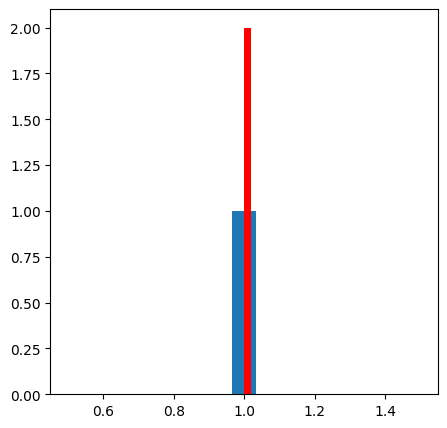

In [41]:
plt.figure(figsize=(5, 5))
control_revenue = data['REVENUE'][(data['VARIANT_NAME'] == 'variant') & (data['REVENUE'] == 1)]
test_revenue = data['REVENUE'][(data['VARIANT_NAME'] == 'control') & (data['REVENUE'] == 1)]
plt.hist(test_revenue, bins=15)
plt.hist(control_revenue, color='r', bins=50)

plt.show()

In [51]:
data['VARIANT_NAME'].value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

Посчитаем, сколько типов встречается у каждого пользователя.

In [53]:
variants = data.groupby('USER_ID', as_index=False).agg({
    'VARIANT_NAME': pd.Series.nunique
})

In [56]:
variants.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


Избавляемся от некорректных данных

In [57]:
more_than_one_types = variants.query('VARIANT_NAME > 1')

In [58]:
data_new = data[~data.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [59]:
data_new.shape, data.shape

((6070, 3), (10000, 3))

Разделим выборки

In [61]:
control = data[data['VARIANT_NAME'] == "control"]
test = data.query('VARIANT_NAME == "variant"')

In [46]:
k1 = data[data['VARIANT_NAME']=='variant']['REVENUE'].sum()
k2 = data[data['VARIANT_NAME']=='control']['REVENUE'].sum()
k1,k2

(351.47, 643.0)

In [45]:
n1, n2 = data['VARIANT_NAME'].value_counts()
n1,n2

(5016, 4984)

In [50]:
z_score, z_pvalue = proportion.proportions_ztest(
    np.array([k1, k2]),
    np.array([n1, n2]),
    )
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))

Results are  z_score =-9.848, pvalue = 0.000


In [64]:
if abs(z_pvalue) < 0.05:
    print("Нулевая гипотеза не подтвердилась!")
else:
    print("Нулевая гипотеза подтвердлась")

Нулевая гипотеза не подтвердилась!


In [63]:
alpha = 0.05

st = shapiro(data.REVENUE)
print('Распределение {}нормальное\n'.format({True:'не ', False:''}[st[1] < alpha]))


Распределение не нормальное



Предварительно можно сделать вывод, что тест был настроен не корректно. Был выбран маленький период проведения теста. есть пользователи, которые попали в обе группы. Возможно метрики были выбраны не коректно, т.к. маленький средний чек. В рекоментациях я рекомендовала бы разобраться со сроками, метриками и поработать над тестируемой гипотезой. Пока сайт оставить без изменений.